In [1]:
#!pip install catboost
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#!pip install -U tqdm

## Necessary imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
import warnings
import pickle
from tqdm.auto import tqdm

from features.helper import *
from features.feature_extractor import feature_extraction

warnings.filterwarnings('ignore')


### Converting original dataset to dataframes
Takes parameters programming language and year

**Currently unnecessary since the contents of the .csv are already stored in the pickle files.**

In [6]:
# df_java_raw = dataframe_from_csv(suffix = ".java", year = "2009")
# df_cpp_raw = dataframe_from_csv(suffix = ".cpp", year = "2009")

### Saving dataset as pickle file

In [7]:
# with open('saved/df_java_raw.pickle', 'wb') as handle:
#     pickle.dump(df_java_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved/df_cpp_raw.pickle', 'wb') as handle:
#     pickle.dump(df_cpp_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Begin here: Dataset and preprocessing
### Import datasets using pickle

In [8]:
# Load pickled data Java
with open('saved/df_java_raw.pickle', 'rb') as handle:
    df_java_raw = pickle.load(handle)

# Load pickled data C++ 
with open('saved/df_cpp_raw.pickle', 'rb') as handle:
    df_cpp_raw = pickle.load(handle)
    
print(f"Number of files for Java: {df_java_raw.shape[0]}")
print(f"Number of files for C++: {df_cpp_raw.shape[0]}")

Number of files for Java: 12029
Number of files for C++: 32403


### Preprocessing dataframe
- Removing unnecessary columns and renaming them
- Removing rows that cannot be parsed

In [9]:
# take important columns and rename
df_java = prepare_dataframe(df_java_raw)
print(f"Number of files after preprocessing - Java: {df_java.shape[0]}")

df_cpp = prepare_dataframe(df_cpp_raw)
print(f"Number of files after preprocessing - C++: {df_cpp.shape[0]}")

Number of files after preprocessing - Java: 12022
Number of files after preprocessing - C++: 32266


## Feature engineering
### Defining sampling hyperparameters


In [7]:
# Hyperparameters for the sample
N_FILES = 9
N_USERS = 250

# set seeds
random.seed(0)
np.random.seed(0)

### Sampling users and their code for feature extraction


In [8]:
# generate samples for n_files from n_users - Java
df_java_sample = sample_from_dataframe(df_java, N_FILES, N_USERS)
print(f"Number of samples for Java: {df_java_sample.shape[0]}")

# generate samples for n_files from n_users - C++
df_cpp_sample = sample_from_dataframe(df_cpp, N_FILES, N_USERS)
print(f"Number of samples for C++: {df_cpp_sample.shape[0]}")

Number of samples for Java: 2250
Number of samples for C++: 2250


### Saving sampled users for generalization experiment

In [9]:
sampled_users = df_java_sample[['user_id','username']].drop_duplicates(ignore_index=True)

with open('saved/sampled_users.pickle', 'wb') as handle:
    pickle.dump(sampled_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Performing feature extraction for each feature type

In [10]:
# extract features from the code - full feature set
java_features_full = pd.DataFrame(feature_extraction(
    df_java_sample, flag_lexical=True, flag_syntax=True))
print(f"Number of features for Java: {java_features_full.shape[1]}")

  0%|          | 0/2250 [00:00<?, ?it/s]

Number of features for Java: 7736


In [11]:
# extract features from the code - only layout features
java_features_layout = pd.DataFrame(feature_extraction(
    df_java_sample, flag_lexical=False, flag_syntax=False))
print(f"Number of features for Java: {java_features_layout.shape[1]}")

  0%|          | 0/2250 [00:00<?, ?it/s]

Number of features for Java: 7


In [12]:
# extract features from the code - layout + syntax features
java_features_syntax = pd.DataFrame(feature_extraction(
    df_java_sample, flag_lexical=False, flag_syntax=True))
print(f"Number of features for Java: {java_features_syntax.shape[1]}")

  0%|          | 0/2250 [00:00<?, ?it/s]

Number of features for Java: 419


In [13]:
# extract features from the code - layout + lexical features
java_features_lexical = pd.DataFrame(feature_extraction(
    df_java_sample, flag_lexical=True, flag_syntax=False))
print(f"Number of features for Java: {java_features_lexical.shape[1]}")

  0%|          | 0/2250 [00:00<?, ?it/s]

Number of features for Java: 7324


In [14]:
# extract features from the code - only layout features in C++
cpp_features_layout = pd.DataFrame(feature_extraction(
    df_cpp_sample, flag_lexical=False, flag_syntax=False))
print(f"Number of features for C++: {cpp_features_layout.shape[1]}")

  0%|          | 0/2250 [00:00<?, ?it/s]

Number of features for C++: 7


## Feature Selection
Based on the mutual information criterion we keep the top N features in each setting. 

In [15]:
from features.helper import feature_selection
N_FEATURES = 2500

# dictionary to save all feature sets
dict_features={}

dict_features["java_features_full"] = feature_selection(java_features_full, N_FEATURES)
dict_features["java_features_layout"]  = feature_selection(java_features_layout, N_FEATURES)
dict_features["java_features_lexical"]  = feature_selection(java_features_lexical, N_FEATURES)
dict_features["java_features_syntax"]  = feature_selection(java_features_syntax, N_FEATURES)
dict_features["cpp_features_layout"]  = feature_selection(cpp_features_layout, N_FEATURES)

Selecting best features...
Feature selection lasted: 84.936575
Number of features selected: 2500
Selecting best features...
Feature selection lasted: 0.050843
Number of features selected: 6
Selecting best features...
Feature selection lasted: 84.977931
Number of features selected: 2500
Selecting best features...
Feature selection lasted: 5.172942
Number of features selected: 418
Selecting best features...
Feature selection lasted: 0.065861
Number of features selected: 6


In [16]:
# Store dictionary with N best features for each combination of feature types
# each language dataset has 250 users with 9 files each
with open('saved/dict_features.pickle', 'wb') as handle:
    pickle.dump(dict_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Import pickled features after selection
We do this so we don't have to recalculate the best features every run.


In [10]:
# Load data (deserialize)
with open('saved/dict_features.pickle', 'rb') as handle:
    dict_features = pickle.load(handle)
for key, value in dict_features.items():
    print (f"Setting {key}: \n Has the following feature dimensions: {value['X'].shape}, and target dimension: {value['y'].shape}")

Setting java_features_full: 
 Has the following feature dimensions: (2250, 2500), and target dimension: (2250,)
Setting java_features_layout: 
 Has the following feature dimensions: (2250, 6), and target dimension: (2250,)
Setting java_features_lexical: 
 Has the following feature dimensions: (2250, 2500), and target dimension: (2250,)
Setting java_features_syntax: 
 Has the following feature dimensions: (2250, 418), and target dimension: (2250,)
Setting cpp_features_layout: 
 Has the following feature dimensions: (2250, 6), and target dimension: (2250,)


## **Modelling and Predictions**
- After running tests to determine the number of features, we found that 750 gives us the best performance

In [18]:
# take only best 750 features
num_features = 750
for key, value in dict_features.items():
    num_features_curr = np.min([num_features, value["X"].shape[1]])
    value["X"] = value["X"].iloc[:,:num_features_curr]
    print (f"Setting {key}: \n Has the following feature dimensions: {value['X'].shape}")


Setting java_features_full: 
 Has the following feature dimensions: (2250, 750)
Setting java_features_layout: 
 Has the following feature dimensions: (2250, 6)
Setting java_features_lexical: 
 Has the following feature dimensions: (2250, 750)
Setting java_features_syntax: 
 Has the following feature dimensions: (2250, 418)
Setting cpp_features_layout: 
 Has the following feature dimensions: (2250, 6)


### Random Forest

In [19]:
# training random forest classifier for each setting and saving validation accuracy
from features.models import *

for key, value in dict_features.items():
    X=value["X"]
    y=value["y"]
    print(key)
    train_accs, valid_accs = random_forest_classifier(X, y)
    # add validation accuracy to dictionary
    dict_features[key]["forest_valid_acc"] = valid_accs

dict_results = dict_features
# pickle updated dictionary
with open('saved/dict_results.pickle', 'wb') as handle:
    pickle.dump(dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

java_features_full
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.95

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.95

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.95

java_features_layout
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.45

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.43

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.43

java_features_lexical
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.96

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.97

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.96

java_features_syntax
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.82

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.82

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.81

cpp_features_layout
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.47

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.48

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.45



### Catboost

In [20]:
# training catboost classifier for each setting and saving validation accuracy
from features.models import *

for key, value in dict_features.items():
    X=value["X"]
    y=value["y"]
    
    print(key)
    
    # for regular feature sets
    rsm = 0.02
    iterations = 500
    
    # for small feature sets
    if X.shape[1] < 10:
        rsm = 0.5
        iterations = 2000
    
    train_accs, valid_accs = catboost_classifier(X, y, rsm, iterations)
    # add validation accuracy to dictionary
    dict_features[key]["catboost_valid_acc"] = valid_accs
    
dict_results = dict_features

# pickle updated dictionary
with open('saved/dict_results.pickle', 'wb') as handle:
    pickle.dump(dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

java_features_full
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.94

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.93

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.95

java_features_layout
Validation #1
Train accuracy: 0.78
Valid accuracy: 0.30

Validation #2
Train accuracy: 0.84
Valid accuracy: 0.35

Validation #3
Train accuracy: 0.86
Valid accuracy: 0.35

java_features_lexical
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.96

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.95

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.94

java_features_syntax
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.80

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.81

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.79

cpp_features_layout
Validation #1
Train accuracy: 0.90
Valid accuracy: 0.37

Validation #2
Train accuracy: 0.85
Valid accuracy: 0.35

Validation #3
Train accuracy: 0.91
Valid accuracy: 0.41



## Load Results

In [11]:
import pickle

# Load data (deserialize)
with open('saved/dict_results.pickle', 'rb') as handle:
    dict_results = pickle.load(handle)


In [23]:
for key, value in dict_results.items():

    dict_results[key]['forest_valid_acc_mean'] = np.mean(dict_results[key]['forest_valid_acc'])    
    dict_results[key]['catboost_valid_acc_mean'] = np.mean(dict_results[key]['catboost_valid_acc'])
    print(f"{key}: \n Random Forest: {dict_results[key]['forest_valid_acc_mean']:0.2f} \n CatBoost: {dict_results[key]['catboost_valid_acc_mean']:0.2f} \n")

java_features_full: 
 Random Forest: 0.95 
 CatBoost: 0.94 

java_features_layout: 
 Random Forest: 0.44 
 CatBoost: 0.33 

java_features_lexical: 
 Random Forest: 0.96 
 CatBoost: 0.95 

java_features_syntax: 
 Random Forest: 0.82 
 CatBoost: 0.80 

cpp_features_layout: 
 Random Forest: 0.47 
 CatBoost: 0.38 

java_expert_features: 
 Random Forest: 0.97 
 CatBoost: 0.96 

java_small_features: 
 Random Forest: 0.98 
 CatBoost: 0.95 



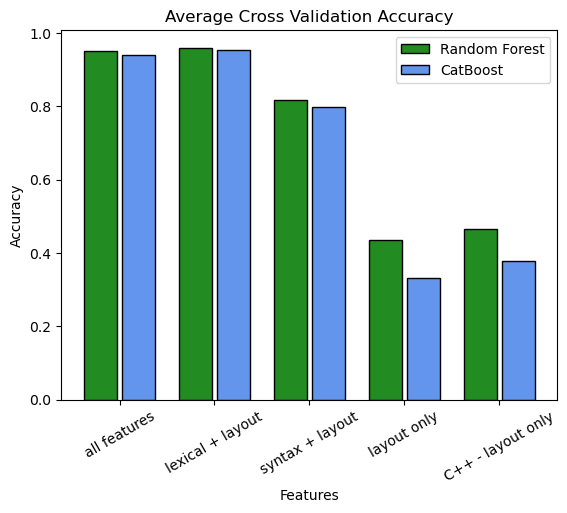

In [13]:
keys_list = ['java_features_full',
 'java_features_lexical',
 'java_features_syntax',
 'java_features_layout',
 'cpp_features_layout']

forest_list = []
catboost_list = []
for key in keys_list:
    forest_list.append(dict_results[key]['forest_valid_acc_mean'])
    catboost_list.append(dict_results[key]['catboost_valid_acc_mean'])

keys_list = ['all features',
 'lexical + layout',
 'syntax + layout',
 'layout only',
 'C++ - layout only']
X_axis = np.arange(len(keys_list))

plt.rcParams.update(plt.rcParamsDefault)

plt.bar(X_axis - 0.2, forest_list, 0.35, label = 'Random Forest', color="forestgreen",edgecolor='black')
plt.bar(X_axis + 0.2, catboost_list, 0.35, label = 'CatBoost', color="cornflowerblue",edgecolor='black' )
plt.xticks(X_axis, keys_list)
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.title("Average Cross Validation Accuracy")
plt.legend()
plt.xticks(rotation=30)
plt.show()    


# Adaptation to Expert Programmers
- load all java data from pickled file
- preprocess as before
- determine hard problems: those that have less than 30 solutions
- extract expert users: those who can solve at least one of the hard problems
- sample code from these users
- extract features and train the model

In [14]:
# Load data Java
with open('saved/df_java_raw.pickle', 'rb') as handle:
    df_java_raw = pickle.load(handle)
print(f"Number of files for Java: {df_java_raw.shape[0]}")

# take important columns and rename
df_java = prepare_dataframe(df_java_raw)
print(f"Number of files for Java after preprocessing: {df_java.shape[0]}")

Number of files for Java: 12029
Number of files for Java after preprocessing: 12022


In [25]:
# get hard problems
hard_problems = get_hard_problems(df_java)
# get expert users, ones that have solved hard problems
expert_users = get_best_users(df_java, hard_problems)

print(f"Number of expert users: {len(expert_users)}")
df_java_expert = df_java[df_java['username'].isin(expert_users)]
print(f"Number of source code files from exper users: {df_java_expert.shape[0]}")


Number of expert users: 74
Number of source code files from exper users: 1136


### Resampling
Due to the small number of code available for expert users, we had to also create a small version of the full dataset in order to have a fair comparison
- 9 files for 65 expert users
- 9 files for 65 random users

In [26]:
# Hyperparameters
N_FILES = 9
N_USERS = 65

# random seeds
random.seed(0)
np.random.seed(0)

In [27]:
# generate samples for n_files from n_users
df_java_expert_sample = sample_from_dataframe(df_java_expert, N_FILES, N_USERS)
df_java_small_sample = sample_from_dataframe(df_java, N_FILES, N_USERS)

print(f"Number of samples for Java: {df_java_expert_sample.shape[0]}")

Number of samples for Java: 585


In [28]:
# For the expert users
# extract features from the code
java_expert_features= pd.DataFrame(feature_extraction(
    df_java_expert_sample, flag_lexical=True, flag_syntax=True))
print(f"Number of features for Java: {java_expert_features.shape[1]}")

  0%|          | 0/585 [00:00<?, ?it/s]

Number of features for Java: 2745


In [29]:
# For the small sample group
# extract features from the code
java_small_features = pd.DataFrame(feature_extraction(
    df_java_small_sample, flag_lexical=True, flag_syntax=True))
print(f"Number of features for Java: {java_small_features.shape[1]}")

  0%|          | 0/585 [00:00<?, ?it/s]

Number of features for Java: 2879


### Feature selection

In [30]:
from features.helper import feature_selection
N_FEATURES = 1500

dict_features={}

dict_features["java_expert_features"] = feature_selection(java_expert_features, N_FEATURES)
dict_features["java_small_features"] = feature_selection(java_small_features, N_FEATURES)

Selecting best features...
Feature selection lasted: 11.274592
Number of features selected: 1500
Selecting best features...
Feature selection lasted: 14.993503
Number of features selected: 1500


In [31]:
#load previous results to update the dictionary
import pickle

# Load data (deserialize)
with open('saved/dict_results.pickle', 'rb') as handle:
    dict_results = pickle.load(handle)

### Training Classifiers
- For both regular and expert users

In [32]:
from features.models import *
for key, value in dict_features.items():
    X=value["X"]
    y=value["y"]
    print(key)
    
    #CatBoost
    train_accs, valid_accs = catboost_classifier(X, y)
    dict_features[key]["catboost_valid_acc"] = valid_accs
    
    #Random Forest
    train_accs, valid_accs = random_forest_classifier(X, y)
    dict_features[key]["forest_valid_acc"] = valid_accs    
    
    dict_results[key] = dict_features[key]    

with open('saved/dict_results.pickle', 'wb') as handle:
    pickle.dump(dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


java_expert_features
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.97

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.94

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.98

Validation #1
Train accuracy: 1.00
Valid accuracy: 0.99

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.96

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.96

java_small_features
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.94

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.93

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.97

Validation #1
Train accuracy: 1.00
Valid accuracy: 0.97

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.99

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.97



### Load pickled results including expert users

In [15]:
with open('saved/dict_results.pickle', 'rb') as handle:
    dict_results = pickle.load(handle)
    

In [22]:
for key, value in dict_results.items():
    dict_results[key]['forest_valid_acc_mean'] = np.mean(dict_results[key]['forest_valid_acc'])
    dict_results[key]['catboost_valid_acc_mean'] = np.mean(dict_results[key]['catboost_valid_acc'])

for key, value in dict_results.items():
    print(key)
    print(f"Random forest: {dict_results[key]['forest_valid_acc_mean']:0.2f}")
    print(f"CatBoost: {dict_results[key]['catboost_valid_acc_mean']:0.2f} \n")

java_features_full
Random forest: 0.95
CatBoost: 0.94 

java_features_layout
Random forest: 0.44
CatBoost: 0.33 

java_features_lexical
Random forest: 0.96
CatBoost: 0.95 

java_features_syntax
Random forest: 0.82
CatBoost: 0.80 

cpp_features_layout
Random forest: 0.47
CatBoost: 0.38 

java_expert_features
Random forest: 0.97
CatBoost: 0.96 

java_small_features
Random forest: 0.98
CatBoost: 0.95 



In [35]:
with open('saved/dict_results_expert.pickle', 'wb') as handle:
    pickle.dump(dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Testing performance for different numbers of features


In [36]:
from features.helper import feature_selection
from features.models import *

number_features = [10,50] + list(range(100,1500,100)) + [1500, 2000, 2500]
dict_test={}
key = "java_features_full"
features = dict_results[key]['X']
targets = dict_results[key]['y']
validation_accs_list =[]
dict_results_testing = dict_results

for num in number_features:
    print(f"*** {num} ***")
    current_features = features.iloc[:,:num]
    
    res_string = f"forest_valid_acc_{num}"
    
    train_accs, valid_accs = random_forest_classifier(current_features, targets, 100)
    
    validation_accs_list.append(np.mean(valid_accs))
    
    dict_results_testing[key][res_string] = valid_accs
    
with open('saved/dict_results_testing.pickle', 'wb') as handle:
    pickle.dump(dict_results_testing, handle, protocol=pickle.HIGHEST_PROTOCOL)

*** 10 ***
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.61

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.56

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.61

*** 50 ***
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.68

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.67

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.70

*** 100 ***
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.74

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.73

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.76

*** 200 ***
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.90

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.90

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.91

*** 300 ***
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.94

Validation #2
Train accuracy: 1.00
Valid accuracy: 0.93

Validation #3
Train accuracy: 1.00
Valid accuracy: 0.93

*** 400 ***
Validation #1
Train accuracy: 1.00
Valid accuracy: 0.95

Validation #2
Trai

In [37]:
with open('saved/dict_results_testing.pickle', 'rb') as handle:
    dict_results_testing = pickle.load(handle)

In [38]:
# retrive all validation accuracies from the pickle file
number_features = [10,50] + list(range(100,1500,100)) + [1500, 2000, 2500]
dict_test={}
key = "java_features_full"
validation_accs_list =[]
features = dict_results_testing[key]['X']
for num in number_features:
    res_string = f"forest_valid_acc_{num}"
    valid_accs = dict_results_testing[key][res_string] 
    validation_accs_list.append(np.mean(valid_accs))
##

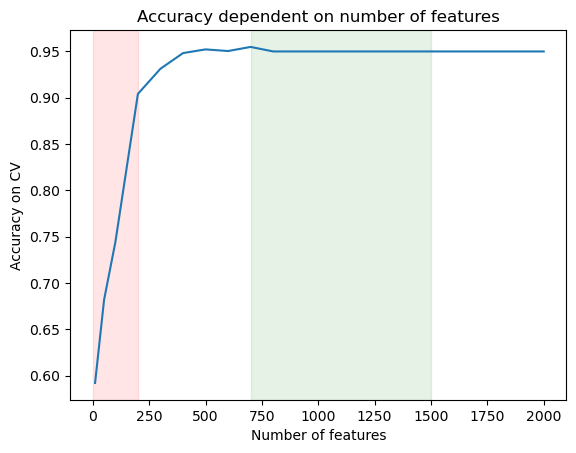

In [39]:
import matplotlib.pyplot as plt
number_features = [10,50] + list(range(100,1500,100)) + [1500, 2000, 2500]

fig, ax = plt.subplots()
ax.plot(number_features[:18], validation_accs_list[:18])
ax.axvspan(700, 1500, alpha=0.1, color='green')
ax.axvspan(0, 200, alpha=0.1, color='red')
plt.xlabel("Number of features")
plt.ylabel("Accuracy on CV")
plt.title("Accuracy dependent on number of features")
#plt.legend()
plt.show()

In [40]:
with open('saved/dict_results_testing.pickle', 'wb') as handle:
    pickle.dump(dict_results_testing, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analyzing type of features

In [25]:
key = "java_features_full"
current_mi = np.flip(dict_results[key]["mi"])
current_X = dict_results[key]["X"]

features_mi_dict = dict(zip(current_X.columns,current_mi))

{'Layout_ln(numTabs/length)': 1.0,
 'Lexical_ln(numFunctions/length)': 0.9530186337173338,
 'Lexical_ln(num_public/length)': 0.9300455886861945,
 'Lexical_stdDevLineLength': 0.9253339509311848,
 'Lexical_ln(numTokens/length)': 0.9115593391629127,
 'Lexical_ln(numLiterals/length)': 0.8714752237747555,
 'Lexical_ln(num_class/length)': 0.8695236955737294,
 'Lexical_ln(numKeywords/length)': 0.8576102250375349,
 'Syntax_javaKeywords_public': 0.8418666250158302,
 'Layout_newLineBeforeOpenBrace': 0.8044331489610709,
 'Lexical_ln(numComments/length)': 0.7986405764920668,
 'Syntax_javaKeywords_class': 0.7919765889429229,
 'Syntax_ASTNodeTypesTF_ClassDeclaration': 0.7707200087300532,
 'Syntax_maxDepthASTNode': 0.7691155875983583,
 'Syntax_ASTNodeBigramsTF_CompilationUnit_ClassDeclaration': 0.769062105920726,
 'Syntax_ASTNodeTypesTF_VariableDeclarator': 0.7572267700934902,
 'Layout_whiteSpaceRatio': 0.7536400325737772,
 'Lexical_avgLineLength': 0.7477319263292138,
 'Syntax_ASTNodeTypesTF_Compilat

In [42]:
# gets features for each feature type (layout, lexical, syntax)

def extract_features_by_type(features_mi_dict, num_features, type_of_feature="layout"):

    feature_dict={}
    
    for key, value in list(features_mi_dict.items())[:num_features]:
        
        if ((key.lower()).startswith(type_of_feature.lower())):
            feature_dict.update({key:value})

            
    return feature_dict

In [43]:
# Calculating the cumulative mutual information for all feature types

# total number of features from 10 to 1500
total_features = [10, 20, 50, 100, 200, 500, 750, 1000, 1500 ]
lex_mi=[]
syn_mi=[]
lay_mi=[]

for num_feature in total_features:
    lexical_features = extract_features_by_type(features_mi_dict, num_feature, "lexical")    
    syntax_features = extract_features_by_type(features_mi_dict, num_feature, "syntax")    
    layout_features = extract_features_by_type(features_mi_dict, num_feature, "layout")  
        
    lex_mi_curr = (np.sum(list(lexical_features.values())))
    syn_mi_curr = (np.sum(list(syntax_features.values())))
    lay_mi_curr = (np.sum(list(layout_features.values())))
    sum_mi = lex_mi_curr + syn_mi_curr + lay_mi_curr
    lex_mi.append(lex_mi_curr/sum_mi)
    syn_mi.append(syn_mi_curr/sum_mi)
    lay_mi.append(lay_mi_curr/sum_mi)

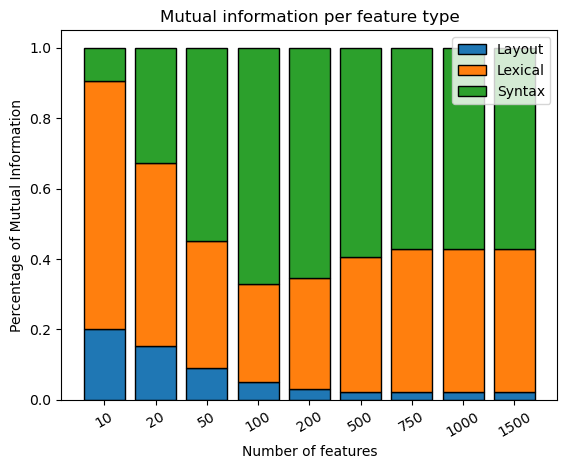

In [44]:
# plotting mutual information values
X_axis = np.arange(len(total_features))

plt.bar(X_axis, lay_mi, label = 'Layout', edgecolor='black')
plt.bar(X_axis, lex_mi, label = 'Lexical', edgecolor='black', bottom= np.array(lay_mi))
plt.bar(X_axis, syn_mi, label = 'Syntax',edgecolor='black', bottom=np.array(lex_mi)+np.array(lay_mi))
np.array(lex_mi)+np.array(syn_mi)+np.array(lay_mi)

plt.rcParams.update(plt.rcParamsDefault)
plt.xticks(X_axis, total_features)
plt.xlabel("Number of features")
plt.ylabel("Percentage of Mutual Information")
plt.title("Mutual information per feature type")
plt.legend()
plt.xticks(rotation=30)
plt.show()    


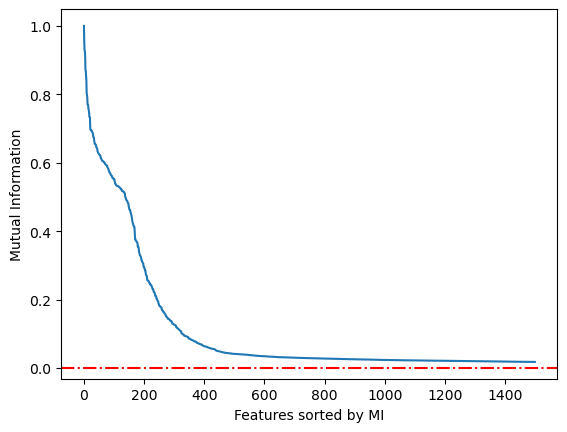

In [45]:
# plotting mutual information per feature
key = "java_features_full"

current_mi = np.flip(dict_results[key]["mi"][-1500:])
plt.plot(current_mi)
plt.axhline(y=0.0, color='r', linestyle='-.')

plt.xlabel("Features sorted by MI")
plt.ylabel("Mutual Information")
plt.show()

### Creating validation data
- Users - those that were sampled from the original data (2009)
- Features - full feature set extracted from 2009 data

**Currently unnecessary since the contents of the .csv are already stored in the pickle files.**

In [46]:
#Extract Java code for 2010
#df_java_raw_validation = dataframe_from_csv(suffix = ".java", year = "2010")
#with open('saved/df_java_raw_validation.pickle', 'wb') as handle:
#    pickle.dump(df_java_raw_validation, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# load the pickled dataset from 2010
with open('saved/df_java_raw_validation.pickle', 'rb') as handle:
    df_java_raw_validation = pickle.load(handle)
    
df_java_validation = prepare_dataframe(df_java_raw_validation)
print(f"Before filtering we have: {df_java_validation.shape[0]} files")

Before filtering we have: 14204 files


In [48]:
# Load the users that were observed during the training
with open('saved/sampled_users.pickle', 'rb') as handle:
    sampled_users = pickle.load(handle)
    
usernames = list(sampled_users['username'])
sampled_users_dict = dict(zip(sampled_users.username,sampled_users.user_id))

#Keep only files for users seen in training
df_java_validation = df_java_validation.loc[df_java_validation.apply(lambda x: x.username in usernames , axis=1)]



In [49]:
# Set the ids to values used during training (user_id is our target variablee)
new_ids = []
for index, row in df_java_validation.iterrows():
    new_ids.append(sampled_users_dict[row['username']])
df_java_validation['user_id'] = new_ids
print(f"After filtering we have: {df_java_validation.shape[0]} files")

After filtering we have: 1775 files


In [50]:
# Perform feature extraction on validation dataset
java_features_validation = pd.DataFrame(feature_extraction(
    df_java_validation, flag_lexical=True, flag_syntax=True))

# Extract the labels (usernames)
y_validation = java_features_validation['user_id']

  0%|          | 0/1775 [00:00<?, ?it/s]

In [51]:
with open('saved/dict_results.pickle', 'rb') as handle:
    dict_results = pickle.load(handle)

# We extract the top 1000 features from the training (java_features_full)
num_features = 1000
value = dict_results['java_features_full']
num_features_curr = np.min([num_features, value["X"].shape[1]])
value["X"] = value["X"].iloc[:,:num_features_curr]

# Features present in the training set and current validation (which need to be fixed)
training_features = list(dict_results['java_features_full']['X'].columns)
validation_features = list(java_features_validation.columns)

common_features = list(set(training_features) & set(validation_features))
difference = list(set(training_features) - set(validation_features))
java_features_validation = java_features_validation[common_features]
java_features_validation = java_features_validation.reindex(java_features_validation.columns.tolist() + difference, axis=1) 

java_features_validation.shape

,Syntax_javaKeywords_assert,Lexical_WordUnigramTF_Point,Lexical_WordUnigramTF_ProblemC,Lexical_WordUnigramTF_prob,Lexical_WordUnigramTF_ii,Syntax_ASTNodeBigramsTF_FormalParameter_BasicType,Lexical_WordUnigramTF_qualification,Syntax_ASTNodeTypesTF_ForStatement,Lexical_WordUnigramTF_parseInt,Syntax_ASTNodeBigramsTF_ForStatement_ForStatement,...,Lexical_WordUnigramTF_ioe,Lexical_WordUnigramTF_width,Lexical_WordUnigramTF_delete,Lexical_WordUnigramTF_isLetter,Lexical_WordUnigramTF_features,Lexical_WordUnigramTF_Alien,Lexical_WordUnigramTF_dict,Lexical_WordUnigramTF_inputFile,Lexical_WordUnigramTF_dictionary,Lexical_WordUnigramTF_alien
0,NaN,NaN,NaN,NaN,NaN,0.004878,NaN,0.014610,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.005682,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.004878,NaN,0.014610,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.005682,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.005682,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770,NaN,NaN,NaN,NaN,NaN,0.015801,NaN,0.006757,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1771,NaN,NaN,NaN,NaN,NaN,0.016055,NaN,0.006865,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1772,NaN,NaN,NaN,NaN,NaN,0.004963,NaN,0.013631,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018405,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fitting model on training data (2009) and validating on test data (2010)

In [52]:
# fitting models
from features.models import *
value = dict_results["java_features_full"]

train_accs_rf = []
valid_accs_rf = []
train_accs_cb = []
valid_accs_cb = []

X_train, X_valid = value["X"], java_features_validation[value["X"].columns]
y_train, y_valid = value["y"], y_validation
X_train.fillna(0, inplace=True)
X_valid.fillna(0, inplace=True)

model_rf = RandomForestClassifier(n_estimators=300, random_state=0)
model_cb = CatBoostClassifier(
            iterations=500, 
            learning_rate=0.2,
            rsm=0.01,
            depth=3,
            bootstrap_type='Bernoulli',
            subsample=0.7,
            loss_function='MultiClass'
        )
model_rf.fit(X_train, y_train)
model_cb.fit(X_train, y_train, plot=False, verbose=False)

y_pred_rf = model_rf.predict(X_train).squeeze()
y_pred_cb = model_cb.predict(X_train).squeeze()

train_acc_rf = np.average(y_train == y_pred_rf)
train_acc_cb = np.average(y_train == y_pred_cb)

print(f'Random Forest Train accuracy: {train_acc_rf:.2f}')
train_accs_rf.append(train_acc_cb)
print(f'CatBoost Train accuracy: {train_acc_cb:.2f}')
train_accs_rf.append(train_acc_cb)

y_pred_rf = model_rf.predict(X_valid).squeeze()
y_pred_cb = model_cb.predict(X_valid).squeeze()

valid_acc_rf = np.average(y_valid == y_pred_rf)
valid_acc_cb = np.average(y_valid == y_pred_cb)

print(f'Random Forest Valid accuracy: {valid_acc_rf:.2f}')
print(f'CatBoost Valid accuracy: {valid_acc_cb:.2f}')

Random Forest Train accuracy: 1.00
CatBoost Train accuracy: 1.00
Random Forest Valid accuracy: 0.78
CatBoost Valid accuracy: 0.77


In [54]:
# adding validation accuracy to the dictionary
dict_results["java_features_full"]["validation_set_forest_accuracy"] = valid_acc_rf
dict_results["java_features_full"]["validation_set_catboost_accuracy"] = valid_acc_cb

In [55]:
# saving the dictionary with pickle
with open('saved/dict_results.pickle', 'wb') as handle:
    pickle.dump(dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
